# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

В процессе анализа я должен ответить на ключевые вопросы:

1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
2. Какие факторы влияют на зарплату у специалистов Data Scientist?
3. Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [1]:
# подключаю все необходимые библеотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# настраиваю визуализацию
sns.set_theme('notebook')
sns.set_palette('Set2')

## Загрузка и обработка данных 

Считываю данные и проверяю датасет на наличие пропусков:

In [2]:
data = pd.read_csv('data/ds_salaries.csv', index_col = [0])
display(data.head(3))
data.info()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


Датасет не имеет пропусков.

Проверяю датасет на наличие дубликатов и удаляю их:

In [3]:
print(f"кол-во полных дубликатов: {data[data.duplicated()].shape[0]}")
data = data.drop_duplicates()
print(f"Размер датасета после удаления: {data.shape}")

кол-во полных дубликатов: 42
Размер датасета после удаления: (565, 11)


Исходя из логики, можно избавиться от столбцов salary и salary_currency, ведь у нас уже есть столбец salary_in_usd, который показывает ЗП в единой валюте.

In [4]:
data = data.drop(axis=1, columns=['salary_currency', 'salary'])
print(f"Размер датасета после удаления неинформативных признаков: {data.shape}")

Размер датасета после удаления неинформативных признаков: (565, 9)


Преобразую признак remote_ratio в категориальный, ведь он содержит всего 3 значения.

In [5]:
data['remote_ratio'] = data['remote_ratio'].apply(
    lambda x:"less 20%" if x == 0 else("50/50" if x == 50 else "more 80%")
)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    object
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(2), object(7)
memory usage: 44.1+ KB


Рассмотрим признак job_title и оптимизируем его, если понадобится 

In [6]:
data['job_title'].value_counts()

Data Scientist                              130
Data Engineer                               121
Data Analyst                                 82
Machine Learning Engineer                    39
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                            

Перенесем все должности, которые упоменаются менее 11 раз в разряд "другое"

In [7]:
data['job_title'] = data['job_title'].apply(
    lambda x: 'other' if len(data[data['job_title']== x])<39 else x
)
data['job_title'].value_counts()

other                        193
Data Scientist               130
Data Engineer                121
Data Analyst                  82
Machine Learning Engineer     39
Name: job_title, dtype: int64

Проверяем employment_type на информативность

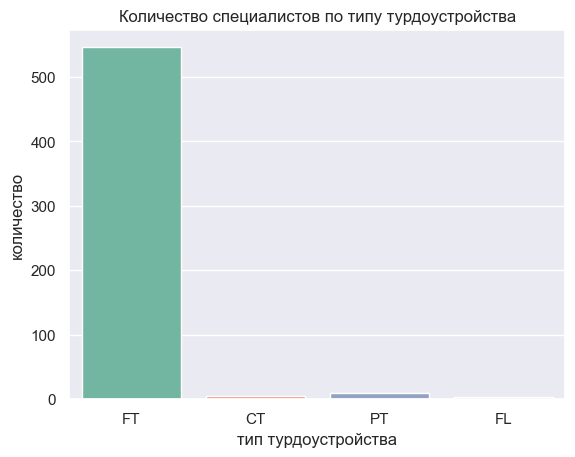

FT    0.966372
PT    0.017699
CT    0.008850
FL    0.007080
Name: employment_type, dtype: float64

In [8]:
fig = sns.countplot(data, x='employment_type')
fig.set(xlabel='тип турдоустройства', ylabel='количество')
plt.title('Количество специалистов по типу турдоустройства')
plt.show()
display(data['employment_type'].value_counts(normalize=True))

Видно, что более 96% значений составляет FT, от чего признак станвоится неинформативным. Удяляю признак.

In [9]:
data = data.drop(axis=1, columns='employment_type')
print(f"Размер датасета после удаления неинформативных признаков: {data.shape}")

Размер датасета после удаления неинформативных признаков: (565, 8)


## Разведывательный анализ данных 

In [10]:
# Готовый к работе датафрейм
data.head()

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,79833,DE,less 20%,DE,L
1,2020,SE,other,260000,JP,less 20%,JP,S
2,2020,SE,other,109024,GB,50/50,GB,M
3,2020,MI,other,20000,HN,less 20%,HN,S
4,2020,SE,Machine Learning Engineer,150000,US,50/50,US,L


### Визуальный анализ данных

Посмотрим на распределение заработной платы:

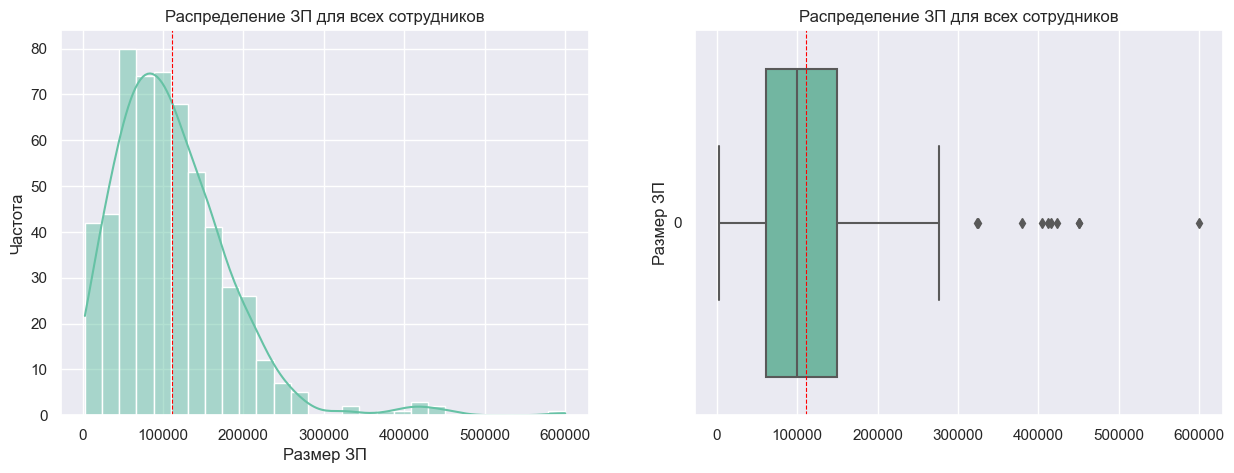

count       565.000000
mean     110610.343363
std       72280.702792
min        2859.000000
25%       60757.000000
50%      100000.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер ЗП', ylabel='Частота')
axes[0].set_title('Распределение ЗП для всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle = '--', linewidth = 0.8)

sns.boxplot(data['salary_in_usd'], orient='h', ax=axes[1])
axes[1].set(ylabel='Размер ЗП')
axes[1].set_title('Распределение ЗП для всех сотрудников')
axes[1].axvline(data['salary_in_usd'].mean(), color='red', linestyle = '--', linewidth = 0.8)

plt.show()
display(data['salary_in_usd'].describe())

Гистограмма напоминает смященное влево нормальное распределения, медиана распределения не соотвествует его среднему значению, также пристутсвуют выбросы. Это говорит нам о том, что распределение ЗП не подчиняется нормальному закону.

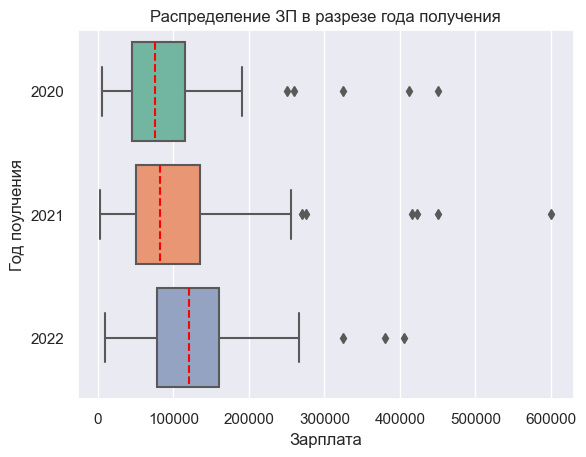

In [12]:
fig = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops ={"color": "red", "linestyle" : "--"})
fig.set(xlabel = 'Зарплата', ylabel ='Год поулчения')
plt.title('Распределение ЗП в разрезе года получения')
plt.show()

Визуалтзация показывает, что ЗП специалистов Data Scientist увеличивается из года в год, этот рост наиболее заметен между 2021 и 2022 годами. Проверим это далее. Для начала рассмотрим другие признаки.

Рассмотрим признак experience_level

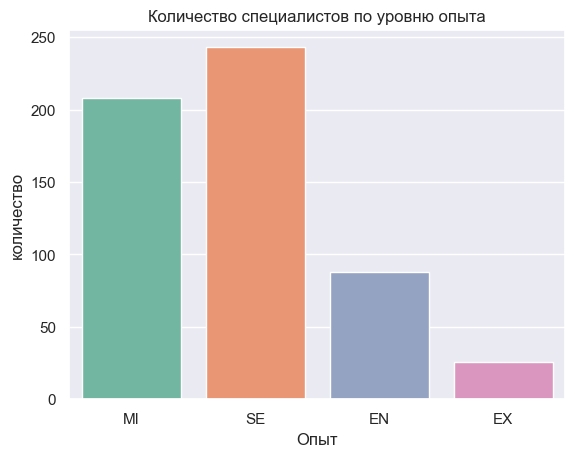

SE    243
MI    208
EN     88
EX     26
Name: experience_level, dtype: int64

In [13]:
fig = sns.countplot(data, x='experience_level')
fig.set(xlabel='Опыт', ylabel='количество')
plt.title('Количество специалистов по уровню опыта')
plt.show()
display(data['experience_level'].value_counts())


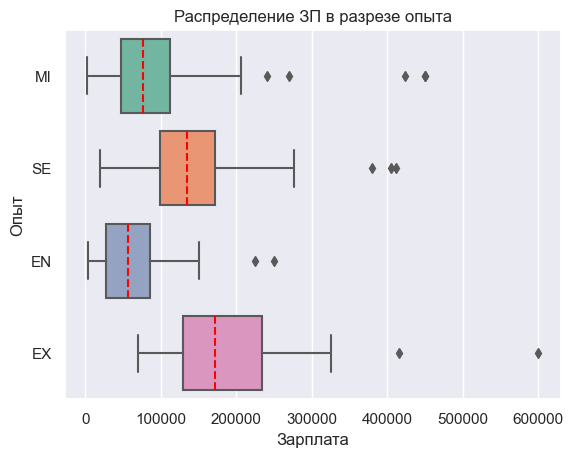

In [14]:
fig = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops ={"color": "red", "linestyle" : "--"})
fig.set(xlabel = 'Зарплата', ylabel ='Опыт')
plt.title('Распределение ЗП в разрезе опыта')
plt.show()

Исходя из визуализации с повышением опыта увеличивается заработная плата, что говорит о влиянии уровня опыта на зарплату.

Рассмотрим признак remote_ratio

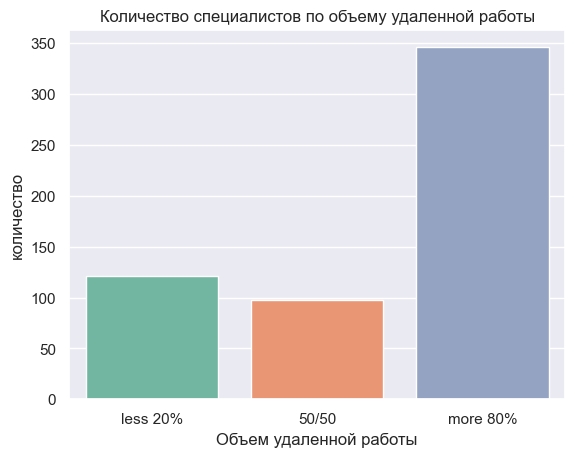

more 80%    346
less 20%    121
50/50        98
Name: remote_ratio, dtype: int64

In [15]:
fig = sns.countplot(data, x='remote_ratio')
fig.set(xlabel='Объем удаленной работы', ylabel='количество')
plt.title('Количество специалистов по объему удаленной работы')
plt.show()
display(data['remote_ratio'].value_counts())


Мы видим что абсолютное большенство специалистов работает полностью или практически полностью удаленно. Проверим зависимость ЗП от этого признака.

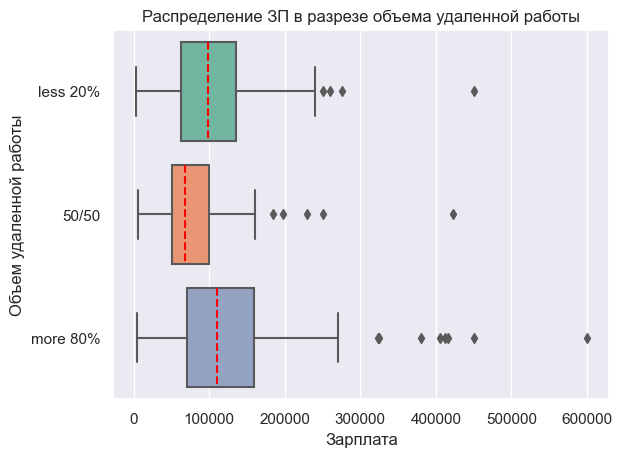

remote_ratio
50/50        80721.897959
less 20%    105785.404959
more 80%    120763.190751
Name: salary_in_usd, dtype: float64


In [16]:
fig = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops ={"color": "red", "linestyle" : "--"})
fig.set(xlabel = 'Зарплата', ylabel ='Объем удаленной работы')
plt.title('Распределение ЗП в разрезе объема удаленной работы')
plt.show()
print(data.groupby('remote_ratio')['salary_in_usd'].mean())

Видно, что сотрудники, работающие поностью(практически полностью) удаленно или же наоборот, получают больше, чем люди работающие частично удаленно. Больше всего получают специалисты на удаленной работе.

Рассмотрим признак company_size

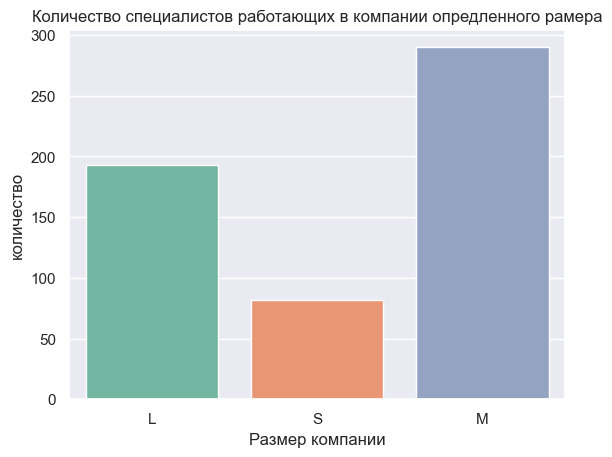

M    290
L    193
S     82
Name: company_size, dtype: int64

In [17]:
fig = sns.countplot(data, x='company_size')
fig.set(xlabel='Размер компании', ylabel='количество')
plt.title('Количество специалистов работающих в компании опредленного рамера')
plt.show()
display(data['company_size'].value_counts())

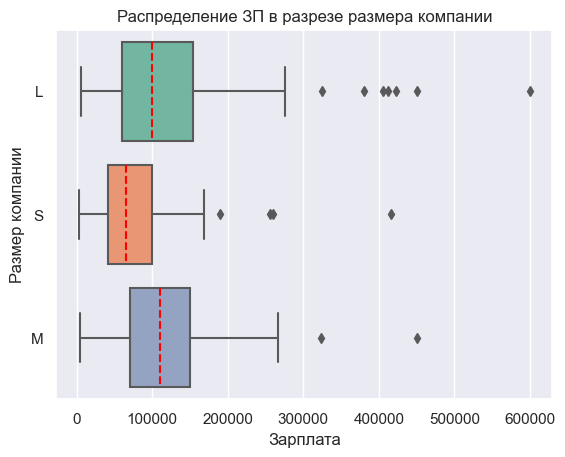

company_size
L    118213.880829
M    114807.079310
S     77872.097561
Name: salary_in_usd, dtype: float64


In [18]:
fig = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops ={"color": "red", "linestyle" : "--"})
fig.set(xlabel = 'Зарплата', ylabel ='Размер компании')
plt.title('Распределение ЗП в разрезе размера компании')
plt.show()

print(data.groupby('company_size')['salary_in_usd'].mean())

Исходя из визуализации, сотрудники компаний малых размеров получают ЗП меньше сотрудников из больших и средних компаний. Разница в ЗП между сотрудниками из больших и средних компаний не так значительна.

Расмотрим признак job_title среди всех должностей

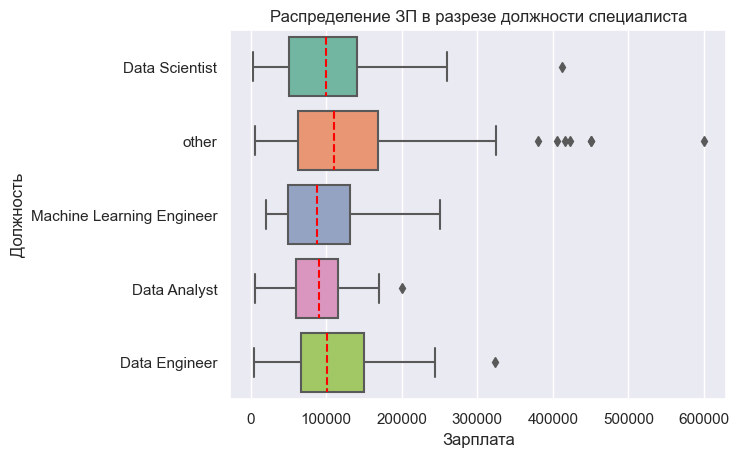

In [19]:
fig = sns.boxplot(data, x='salary_in_usd', y='job_title', orient='h', medianprops ={"color": "red", "linestyle" : "--"})
fig.set(xlabel = 'Зарплата', ylabel ='Должность')
plt.title('Распределение ЗП в разрезе должности специалиста')
plt.show()

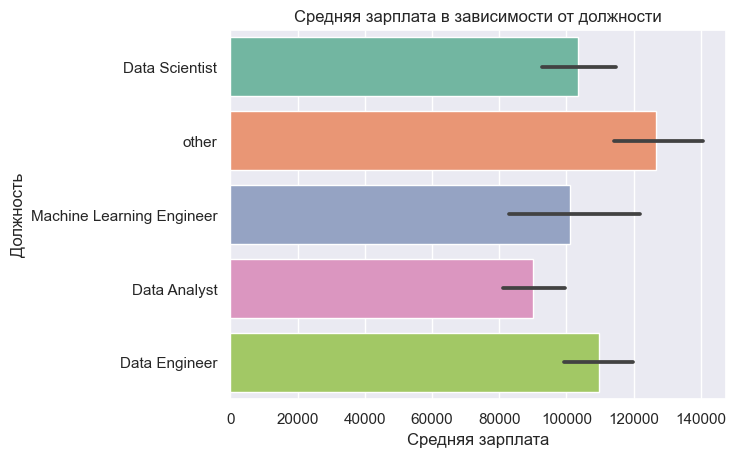

job_title
Data Analyst                  90089.597561
Machine Learning Engineer    101165.128205
Data Scientist               103336.353846
Data Engineer                109750.033058
other                        126676.564767
Name: salary_in_usd, dtype: float64


In [20]:
fig = sns.barplot(data, y='job_title', x='salary_in_usd', orient='h')
fig.set(ylabel='Должность', xlabel='Средняя зарплата')
plt.title('Средняя зарплата в зависимости от должности')
plt.show()
print(data.groupby('job_title')['salary_in_usd'].mean().sort_values())

Мы видим, что сотрудники на должностях Data Scientist и Machine Learning Enginee получают примерно одинакого. Data Analyst специальсты получют меньше приерно на 10%. ЗП Data Engineer специалистов самая высокая из этой четверки, но ниже среднего показателя ЗП по всем остальным должностям, что возможно говорит нам о выбросах. Что касается остальных должностей, достверные выводы по ним сделать практически невозможно, ведь выборка будет совсем незначительной на фоне остальных.

Рассмотрим связь между наличием должностей Data Scientist и Data Engineer и размером компании

In [21]:
group_data = data.groupby('company_size')['job_title'].value_counts()
display(group_data)

company_size  job_title                
L             other                        90
              Data Scientist               43
              Data Engineer                34
              Data Analyst                 13
              Machine Learning Engineer    13
M             Data Engineer                81
              other                        67
              Data Scientist               66
              Data Analyst                 62
              Machine Learning Engineer    14
S             other                        36
              Data Scientist               21
              Machine Learning Engineer    12
              Data Analyst                  7
              Data Engineer                 6
Name: job_title, dtype: int64

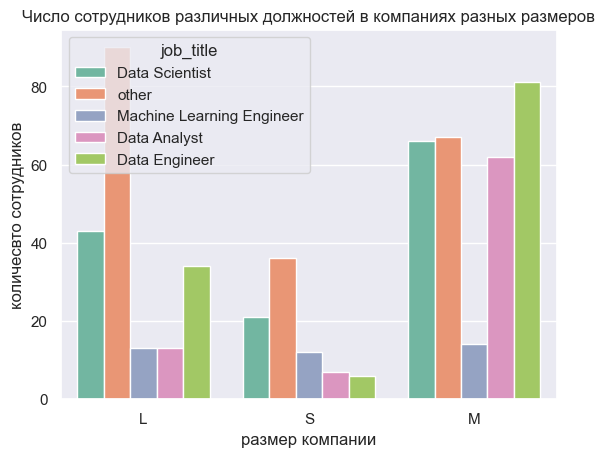

In [22]:
fig = sns.countplot(x='company_size', hue='job_title', data=data) 
fig.set(ylabel='количесвто сотрудников', xlabel='размер компании')
plt.title('Число сотрудников различных должностей в компаниях разных размеров')
plt.show()

На первый взгляд никакой зависимости между размером компании и должностями Data Scientist и Data Engineer нет. Специалистов из крупных и средних компаний на должности Data Scientist около 22% от общего числа, в малых же 25%. Процентное содержание сотрудников на должность Data Engineer в компаниях S=7.3%, M=27.9%, L=17.6% Также сложно сделать какой-то вывод, исходя из того, что в датасете отсутствуют названия компаний, в которых работают сотрудники, так можно было бы проанализировать сотрудников разных должностей в рамках одной компании и сделать выводы.

**Промежуточные выводы:**

* Ежегодный рост зарплат у специалистов Data Scientist есть
* На зарплату у специалистов Data Scientist влияют такие факторы как уровень опыта, размер компании и объем удаленной работы.
* ЗП Data Engineer немного выше чем у Data Scientist
* Связи между наличием должностей Data Scientist и Data Engineer и размером компании нет

### Статистический анализ данных

In [23]:
alpha = 0.05

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

#### Есть ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): ЗП в последующем году ($μ_1$) статистически меньше или равна ЗП в предыдущем году ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): ЗП в последующем году ($μ_1$) статистически больше ЗП в предыдущем году ($μ_2$)

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [24]:
# Определим p-value для выборки по каждому году

mask = data['work_year'] == 2020
mask2 = data['work_year'] == 2021
mask3 = data['work_year'] == 2022
data_2020 = data.loc[mask, 'salary_in_usd']
data_2021 = data.loc[mask2, 'salary_in_usd']
data_2022 = data.loc[mask3, 'salary_in_usd']

print('для 2020года:')
result = stats.shapiro(data_2020)
decision_normality(result[1])

print('\nдля 2021года:')
result = stats.shapiro(data_2021)
decision_normality(result[1])

print('\nдля 2022года:')
result = stats.shapiro(data_2022)
decision_normality(result[1])

для 2020года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для 2021года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для 2022года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [25]:
# Воспользуемся методом U-критерия Манна — Уитни для проверки гипотезы с 2020 до 2021 и с 2021 до 2022 года

_, p1 = stats.mannwhitneyu(data_2020, data_2021)
_, p2 = stats.mannwhitneyu(data_2021, data_2022)

#Интерпретируем результат
print('C 2020 до 2021:')
decision_hypothesis(p1)

print('\nC 2021 до 2022:')
decision_hypothesis(p2)

C 2020 до 2021:
p-value = 0.498
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

C 2021 до 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* ***Мы можем сделать вывод, что ЗП специалистов Data Scientist не увеличивается ежегодно, рост ЗП произошел только за последний год с 2021 по 2022***

#### Влияет ли на ЗП Data Scientist специалистов такие факторы как уровень опыта, размер компании и объем удаленной работы?

#####  Рассмотрим влияние уровня опыта

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): ЗП для опыта==MI ($μ_1$) статистически равна ЗП для опыта==SE ($μ_2$) статистически равна ЗП для опыта==EN ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_0$): ЗП для опыта==MI ($μ_1$) статистически не равна ЗП для опыта==SE ($μ_2$) статистически не равна ЗП для опыта==EN ($μ_3$)

$$ H_0 : μ_1 != μ_2 != μ_3$$

In [26]:
# Определим p-value для выборки по каждому уровню опыта
mask = data['experience_level'] =='MI'
mask2 = data['experience_level'] =='SE'
mask3 = data['experience_level'] =='EN'

data_MI = data.loc[mask, 'salary_in_usd']
data_SE = data.loc[mask2, 'salary_in_usd']
data_EN = data.loc[mask3, 'salary_in_usd']

print('для MI:')
result = stats.shapiro(data_MI)
decision_normality(result[1])

print('\nдля SE:')
result = stats.shapiro(data_SE)
decision_normality(result[1])

print('\nдля EN:')
result = stats.shapiro(data_EN)
decision_normality(result[1])

для MI:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для EN:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [27]:
# Применим критерий Краскела — Уоллиса

# проводим тест
_, p = stats.kruskal(data_MI, data_SE, data_EN)

# интерпретируем результат
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#####  Рассмотрим влияние размера компании

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): Зарплата работников мелкой компании(S) ($μ_1$) статистически равна зpарплате работников средней компании(M) ($μ_2$) и статистически равна зpарплате работников крупной компании(L) ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*  ($H_1$): Зарплата работников мелкой компании(S) ($μ_1$) статистически не равна зpарплате работников средней компании(M) ($μ_2$) и статистически не равна зpарплате работников крупной компании(L) ($μ_3$)

$$ H_1 : μ_1 != μ_2 != μ_3$$

In [28]:
# Определим p-value для выборки по размеру компании
mask = data['company_size'] =='S'
mask2 = data['company_size'] =='M'
mask3 = data['company_size'] =='L'

data_S = data.loc[mask, 'salary_in_usd']
data_M = data.loc[mask2, 'salary_in_usd']
data_L = data.loc[mask3, 'salary_in_usd']

print('для малой компании:')
result = stats.shapiro(data_S)
decision_normality(result[1])

print('\nдля средней компании:')
result = stats.shapiro(data_M)
decision_normality(result[1])

print('\nдля крупной компании:')
result = stats.shapiro(data_L)
decision_normality(result[1])

для малой компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для средней компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [29]:
# Применим критерий Краскела — Уоллиса

# проводим тест
_, p = stats.kruskal(data_S, data_M, data_L)

# интерпретируем результат
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#####  Рассмотрим влияние удаленного типа работы на ЗП

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): Зарплата работников, работающих полностью удаленно ($μ_1$) статистически равна зpарплате работников, работающих частично удаленно ($μ_2$) и статистически равна зpарплате работников, не работающих удаленно(или очень мало) ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*($H_1$) Зарплата работников, работающих полностью удаленно ($μ_1$) статистически не равна зpарплате работников, работающих частично удаленно ($μ_2$) и статистически не равна зpарплате работников, не работающих удаленно(или очень мало) ($μ_3$)
$$ H_1 : μ_1 != μ_2 != μ_3$$

In [30]:
# Определим p-value для выборки по удаленной работе
mask = data['remote_ratio'] =='more 80%'
mask2 = data['remote_ratio'] =='50/50'
mask3 = data['remote_ratio'] =='less 20%'

data_more = data.loc[mask, 'salary_in_usd']
data_50 = data.loc[mask2, 'salary_in_usd']
data_less = data.loc[mask3, 'salary_in_usd']

print('для удаленных работников:')
result = stats.shapiro(data_more)
decision_normality(result[1])

print('\nдля частично удаленных работников:')
result = stats.shapiro(data_50)
decision_normality(result[1])

print('\nдля неудаленных работников:')
result = stats.shapiro(data_less)
decision_normality(result[1])

для удаленных работников:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для частично удаленных работников:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

для неудаленных работников:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [31]:
# Применим критерий Краскела — Уоллиса

# проводим тест
_, p = stats.kruskal(data_more, data_50, data_less)

# интерпретируем результат
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* ***Мы можем сделать вывод, что на зарплату специалистов Data Scientist влияют такие факторы как размер компании, уровень опыта работы в сфере и общий объём работы, выполняемой удалённо.***

#### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза* ($H_0$): Зарплата Data Scientist ($μ_1$) статистически равна зpарплате Data Engineer ($μ_2$)
$$ H_0 : μ_1 = μ_2$$

*Нулевая гипотеза* ($H_1$): Зарплата Data Scientist ($μ_1$) статистически не равна зpарплате Data Engineer ($μ_2$)
$$ H_1 : μ_1 != μ_2$$

In [32]:
# Определим p-value для Data Scientist и Data Engineer специалистов для компаний разных размеров
mask1 = data['job_title'] =='Data Scientist'
mask2 = data['job_title'] =='Data Engineer'

masks = data['company_size'] =='S'
maskm = data['company_size'] =='M'
maskl = data['company_size'] =='L'

Data_Scientist_s =  data.loc[mask1 & masks, 'salary_in_usd']
Data_Engineer_s = data.loc[mask2 & masks, 'salary_in_usd']

Data_Scientist_m = data.loc[mask1 & maskm, 'salary_in_usd']
Data_Engineer_m = data.loc[mask2 & maskm, 'salary_in_usd']

Data_Scientist_l = data.loc[mask1 & maskl, 'salary_in_usd']
Data_Engineer_l = data.loc[mask2 & maskl, 'salary_in_usd']

print('\nдля Data Scientist из мелкой компании:')
result = stats.shapiro(Data_Scientist_s)
decision_normality(result[1])
print('для Data Engineer из мелкой компании:')
result = stats.shapiro(Data_Engineer_s)
decision_normality(result[1])

print('\nдля Data Scientist из средней компании:')
result = stats.shapiro(Data_Scientist_m)
decision_normality(result[1])
print('для Data Engineer из средней компании:')
result = stats.shapiro(Data_Engineer_m)
decision_normality(result[1])

print('\nдля Data Scientist из крупной компании:')
result = stats.shapiro(Data_Scientist_l)
decision_normality(result[1])
print('для Data Engineer из крупной компании:')
result = stats.shapiro(Data_Engineer_l)
decision_normality(result[1])


для Data Scientist из мелкой компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
для Data Engineer из мелкой компании:
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

для Data Scientist из средней компании:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
для Data Engineer из средней компании:
p-value = 0.085
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

для Data Scientist из крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
для Data Engineer из крупной компании:
p-value = 0.109
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [33]:
# проведем тест двувыборочный t-критерий для выборок из мелких и средних компаний

# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий(малая компания)')
result = stats.levene(Data_Scientist_s, Data_Engineer_s)
p = result[1]

if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
    
print('\nТест на равенство дисперсий(средняя компания)')
result = stats.levene(Data_Scientist_m, Data_Engineer_m)
p = result[1]

if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий(малая компания)
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство дисперсий(средняя компания)
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [34]:
# проводим тест на сравнение средних в группах
print('Для малой компании:')
_, p1 = stats.ttest_ind(Data_Scientist_s, Data_Engineer_s, equal_var=True)
decision_hypothesis(p1)

print('\nДля средней компании:')
_, p2 = stats.ttest_ind(Data_Scientist_m, Data_Engineer_m, equal_var=True)
decision_hypothesis(p2)

Для малой компании:
p-value = 0.346
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Для средней компании:
p-value = 0.860
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [35]:
# проведем тест U-критерий Манна — Уитни для крупной компании
_, p3 = stats.mannwhitneyu(Data_Scientist_l, Data_Engineer_l)

print('В крупных компаниях:')
decision_hypothesis(p3)

В крупных компаниях:
p-value = 0.902
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


* ***Мы можем сделать вывод, что зарплаты Data Scientist и Data Engineer специальстов соотносятся одинакого в рамках компаний разных размеров.***

#### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативную гипотезы:**

*Нулевая гипотеза*: Между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: Между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

In [36]:
# составляем таблицу сопряжённости

data_new = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
cross_table = pd.crosstab(data_new['company_size'], data_new['job_title'])

display(cross_table)

job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


In [37]:
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


* ***Мы можем сделать вывод, что Между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь.***

## Выводы:

* Между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь.
* Зарплаты Data Scientist и Data Engineer специальстов соотносятся одинакого в рамках компаний разных размеров.
* ЗП специалистов Data Scientist не увеличивается ежегодно, рост ЗП произошел только за последний год с 2021 по 2022
* На зарплату специалистов Data Scientist влияют такие факторы как размер компании, уровень опыта работы в сфере и общий объём работы, выполняемой удалённо.